# 0 - Prelim

In [1]:
import os
import luigi
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
PROJECT_DIR = os.path.join(os.getcwd(), os.pardir)
os.chdir(PROJECT_DIR)
from src.features.dtm import CreateDTM
from itertools import product

In [2]:
PROJECT_DIR = "C:\\Users\\wertu\\Documents\\Datascience\\udacity-ml-capstone"
os.chdir(PROJECT_DIR)

In [3]:
# This task ensures that the document-term matrices for both train and test are available.
luigi.build([CreateDTM()], local_scheduler = True)

DEBUG: Checking if CreateDTM() is complete
INFO: Informed scheduler that task   CreateDTM__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=480276968, workers=1, host=DESKTOP-6UJS098, username=wertu, pid=21392) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 present dependencies were encountered:
    - 1 CreateDTM()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

In [4]:
#load the data
features = joblib.load("data/processed/dtm_features.pkl")
train = joblib.load("data/interim/train.pkl")
test = joblib.load("data/interim/test.pkl")

# 1 - Introduction

This notebooks explores whether there are non-linear relationships between words that could explain the "funniniess" of a joke. Decision trees are a good algorithm for non linearities.

Pariualry good since they can produce good praiblity sestimes, that are neded for cimputing aureau udner the cruve.

# 2- Validation Set

Create a validation set to be used for parameter searching.

# 3 - Basic Trees

I first train some "basic" trees. A single decision tree by itself is prone to overfitting. Therefore some pruning is needed.

## 3.1 Hyperparameter search

In [12]:
## 3.1 - Feature Importance

# 2 - Bagged Trees (Random Forest)

The first model that I will try will be random forest. Random forests are good because they do not require many hyper parmerts.

"The random forests algorithm, which is also an ensemble-of-trees method, is generally regarded to be among the very best
commonly used classifiers (Manuel Fern´andez-Delgado and Amorim, 2014)" from "AdaBoost and Random Forests: the Power of Interpolation<


## Hyperparameter search

Despite random forests not needing too many

I will use the out of bag error as the criteria. I will search over some parameters.

The morst import parameters are the numer of trees (n_estimators) and the number of features that are considered at each split (max_features). For max_features, I will try

>_"The study of error estimates for bagged classifiers in Breiman [1996b], gives empirical evidence to show that the out-   of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set."_

In [6]:
from math import log

In [13]:
log10 = int(log(features["train"].shape[0],10))

In [14]:
log10

5

In [15]:
params = {'n_estimators' : [50, 100, 300, 500, 1000],
         'max_features':['log2', log10]}
grid = (dict(zip(params, x)) for x in product(*params.values()))

In [16]:
%%time
results = []
for params in grid:
    print(params)
    rf = RandomForestClassifier(**params, n_jobs=10, oob_score = True)
    rf.fit(features["train"], train.funny)
    score = rf.oob_score_
    print(score)
    results.append((params, score))

{'n_estimators': 50, 'max_features': 'log2'}
0.659267452292
{'n_estimators': 50, 'max_features': 5}
0.657677173381
{'n_estimators': 100, 'max_features': 'log2'}
0.677051052031
{'n_estimators': 100, 'max_features': 5}
0.675608587506
{'n_estimators': 300, 'max_features': 'log2'}
0.689640760072
{'n_estimators': 300, 'max_features': 5}
0.690823275159
{'n_estimators': 500, 'max_features': 'log2'}
0.692923258848
{'n_estimators': 500, 'max_features': 5}
0.69522712445
{'n_estimators': 1000, 'max_features': 'log2'}
0.695813284945
{'n_estimators': 1000, 'max_features': 5}
0.696812306312
Wall time: 7h 18min 42s


In [22]:
rf.score(features["test"], test.funny)

0.69965748537177108

In [7]:
%%time
results = []
for params in grid:
    print(params)
    rf = RandomForestClassifier(**params, n_jobs=-1, oob_score = True)
    rf.fit(features["train"], train.funny)
    score = rf.oob_score_
    print(score)
    results.append((params, score))

{'n_estimators': 50, 'max_features': 'log2'}
0.660500937857
{'n_estimators': 50, 'max_features': 'sqrt'}
0.659466237155
{'n_estimators': 50, 'max_features': 6}
0.65897182352
{'n_estimators': 100, 'max_features': 'log2'}
0.67555251998
{'n_estimators': 100, 'max_features': 'sqrt'}
0.672203759582
{'n_estimators': 100, 'max_features': 6}
0.676836976023
{'n_estimators': 300, 'max_features': 'log2'}
0.690430802479
{'n_estimators': 300, 'max_features': 'sqrt'}
0.680787188061
{'n_estimators': 300, 'max_features': 6}
0.689656051215
{'n_estimators': 500, 'max_features': 'log2'}
0.693550195727
{'n_estimators': 500, 'max_features': 'sqrt'}
0.683524302724
{'n_estimators': 500, 'max_features': 6}
0.694727613766
Wall time: 5h 10min 33s


In [21]:
rf.score(features["test"], test.funny)

0.69965748537177108

In [14]:
test_probs = rf.predict_proba(features["test"])

In [16]:
test_probs

array([[ 0.45      ,  0.55      ],
       [ 0.738     ,  0.262     ],
       [ 0.50133333,  0.49866667],
       ..., 
       [ 0.464     ,  0.536     ],
       [ 0.65983333,  0.34016667],
       [ 0.529     ,  0.471     ]])

In [39]:
roc_auc_score(test.funny.astype('int'), test_probs[:, 1])

0.75443582651108088

In [27]:
from sklearn.metrics import roc_curve, auc

In [43]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0], _ = roc_curve(test.funny.values, test_probs[:, 1])
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test.funny.values.ravel(), test_probs[:, 1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [41]:
fpr

{0: array([  0.00000000e+00,   9.03342367e-04,   9.72830241e-04, ...,
          9.99861024e-01,   9.99861024e-01,   1.00000000e+00]),
 'micro': array([  0.00000000e+00,   9.03342367e-04,   9.72830241e-04, ...,
          9.99861024e-01,   9.99861024e-01,   1.00000000e+00])}

In [35]:
import matplotlib.pyplot as plt

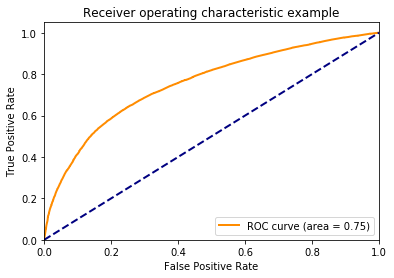

In [44]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Test error and feature importance

# Boosted Trees

## Hyperparameter search

In [9]:
class EarlyStopper():
    def __init__(self, validation_set, validation_labels, patience = 0, verbose = 0):
        self.validation_set = validation_set
        self.validation_labels = validation_labels
        self.accuracy = []
        self.loss = []
        self.preds = None
        self.probs = None
        self.patience = patience
        self.lowest_loss = np.inf
        self.lowest_loss_iter = 0
        self.verbose = verbose
        
    def __call__(self, i, estimator, fit_stage_locals):
        
        if i == 0:
            self.preds = estimator.staged_predict(self.validation_set)
            self.probs = estimator.staged_predict_proba(self.validation_set)
            
        preds = next(self.preds)
        probs = next(self.probs)
        
        acc = np.mean(preds == self.validation_labels )
        loss = log_loss(self.validation_labels, probs)
        
        self.accuracy.append(acc)
        self.loss.append(loss)
        
        
        
        log = ["Iteration: {}".format(i), "Loss: {0:.5f}".format(loss), "Accuracy: {0:.3f}".format(acc)]

        if self.verbose > 0:
            print("  ".join(log))
        
        if  loss < self.lowest_loss:
            self.lowest_loss = loss
            self.lowest_loss_iter = i
            new_low = True
        
        if (min(self.loss[max((i-self.patience),0):i+1]) > self.lowest_loss) & (i > self.patience):
            return True
        else:
         
            return False
        

In [10]:
gmb_stopper = EarlyStopper(features["test"], test.funny.values.astype(np.int64), patience = 25, verbose = 1)
gbm = GradientBoostingClassifier(n_estimators=2000, max_depth = 4, learning_rate=0.1)
gbm.fit(features["train"], train.funny.values.astype(np.int64), monitor = gmb_stopper)

Iteration: 0  Loss: 0.68711  Accuracy: 0.590
Iteration: 1  Loss: 0.68238  Accuracy: 0.592
Iteration: 2  Loss: 0.67846  Accuracy: 0.597
Iteration: 3  Loss: 0.67520  Accuracy: 0.598
Iteration: 4  Loss: 0.67256  Accuracy: 0.599
Iteration: 5  Loss: 0.67014  Accuracy: 0.601
Iteration: 6  Loss: 0.66798  Accuracy: 0.601
Iteration: 7  Loss: 0.66638  Accuracy: 0.602
Iteration: 8  Loss: 0.66479  Accuracy: 0.603
Iteration: 9  Loss: 0.66349  Accuracy: 0.604
Iteration: 10  Loss: 0.66232  Accuracy: 0.605
Iteration: 11  Loss: 0.66129  Accuracy: 0.606
Iteration: 12  Loss: 0.66041  Accuracy: 0.605
Iteration: 13  Loss: 0.65958  Accuracy: 0.606
Iteration: 14  Loss: 0.65889  Accuracy: 0.606
Iteration: 15  Loss: 0.65821  Accuracy: 0.606
Iteration: 16  Loss: 0.65754  Accuracy: 0.606
Iteration: 17  Loss: 0.65692  Accuracy: 0.607
Iteration: 18  Loss: 0.65645  Accuracy: 0.608
Iteration: 19  Loss: 0.65600  Accuracy: 0.608
Iteration: 20  Loss: 0.65557  Accuracy: 0.608
Iteration: 21  Loss: 0.65518  Accuracy: 0.60

Iteration: 177  Loss: 0.63996  Accuracy: 0.629
Iteration: 178  Loss: 0.63988  Accuracy: 0.629
Iteration: 179  Loss: 0.63984  Accuracy: 0.630
Iteration: 180  Loss: 0.63978  Accuracy: 0.630
Iteration: 181  Loss: 0.63971  Accuracy: 0.630
Iteration: 182  Loss: 0.63968  Accuracy: 0.630
Iteration: 183  Loss: 0.63961  Accuracy: 0.630
Iteration: 184  Loss: 0.63958  Accuracy: 0.630
Iteration: 185  Loss: 0.63957  Accuracy: 0.630
Iteration: 186  Loss: 0.63952  Accuracy: 0.630
Iteration: 187  Loss: 0.63948  Accuracy: 0.630
Iteration: 188  Loss: 0.63945  Accuracy: 0.630
Iteration: 189  Loss: 0.63941  Accuracy: 0.631
Iteration: 190  Loss: 0.63939  Accuracy: 0.631
Iteration: 191  Loss: 0.63931  Accuracy: 0.631
Iteration: 192  Loss: 0.63926  Accuracy: 0.631
Iteration: 193  Loss: 0.63923  Accuracy: 0.631
Iteration: 194  Loss: 0.63919  Accuracy: 0.631
Iteration: 195  Loss: 0.63915  Accuracy: 0.631
Iteration: 196  Loss: 0.63910  Accuracy: 0.631
Iteration: 197  Loss: 0.63902  Accuracy: 0.631
Iteration: 19

Iteration: 352  Loss: 0.63414  Accuracy: 0.639
Iteration: 353  Loss: 0.63414  Accuracy: 0.639
Iteration: 354  Loss: 0.63410  Accuracy: 0.639
Iteration: 355  Loss: 0.63409  Accuracy: 0.639
Iteration: 356  Loss: 0.63407  Accuracy: 0.639
Iteration: 357  Loss: 0.63406  Accuracy: 0.639
Iteration: 358  Loss: 0.63404  Accuracy: 0.639
Iteration: 359  Loss: 0.63400  Accuracy: 0.639
Iteration: 360  Loss: 0.63397  Accuracy: 0.639
Iteration: 361  Loss: 0.63393  Accuracy: 0.639
Iteration: 362  Loss: 0.63391  Accuracy: 0.639
Iteration: 363  Loss: 0.63388  Accuracy: 0.640
Iteration: 364  Loss: 0.63383  Accuracy: 0.640
Iteration: 365  Loss: 0.63379  Accuracy: 0.640
Iteration: 366  Loss: 0.63378  Accuracy: 0.640
Iteration: 367  Loss: 0.63376  Accuracy: 0.640
Iteration: 368  Loss: 0.63375  Accuracy: 0.640
Iteration: 369  Loss: 0.63370  Accuracy: 0.640
Iteration: 370  Loss: 0.63367  Accuracy: 0.640
Iteration: 371  Loss: 0.63364  Accuracy: 0.640
Iteration: 372  Loss: 0.63362  Accuracy: 0.640
Iteration: 37

Iteration: 527  Loss: 0.63042  Accuracy: 0.644
Iteration: 528  Loss: 0.63039  Accuracy: 0.644
Iteration: 529  Loss: 0.63041  Accuracy: 0.644
Iteration: 530  Loss: 0.63035  Accuracy: 0.644
Iteration: 531  Loss: 0.63034  Accuracy: 0.644
Iteration: 532  Loss: 0.63035  Accuracy: 0.644
Iteration: 533  Loss: 0.63034  Accuracy: 0.644
Iteration: 534  Loss: 0.63031  Accuracy: 0.644
Iteration: 535  Loss: 0.63031  Accuracy: 0.644
Iteration: 536  Loss: 0.63031  Accuracy: 0.644
Iteration: 537  Loss: 0.63029  Accuracy: 0.644
Iteration: 538  Loss: 0.63026  Accuracy: 0.644
Iteration: 539  Loss: 0.63023  Accuracy: 0.644
Iteration: 540  Loss: 0.63020  Accuracy: 0.644
Iteration: 541  Loss: 0.63019  Accuracy: 0.645
Iteration: 542  Loss: 0.63018  Accuracy: 0.645
Iteration: 543  Loss: 0.63015  Accuracy: 0.644
Iteration: 544  Loss: 0.63012  Accuracy: 0.644
Iteration: 545  Loss: 0.63010  Accuracy: 0.644
Iteration: 546  Loss: 0.63007  Accuracy: 0.645
Iteration: 547  Loss: 0.63005  Accuracy: 0.645
Iteration: 54

Iteration: 702  Loss: 0.62749  Accuracy: 0.649
Iteration: 703  Loss: 0.62745  Accuracy: 0.649
Iteration: 704  Loss: 0.62742  Accuracy: 0.649
Iteration: 705  Loss: 0.62743  Accuracy: 0.649
Iteration: 706  Loss: 0.62737  Accuracy: 0.649
Iteration: 707  Loss: 0.62735  Accuracy: 0.649
Iteration: 708  Loss: 0.62732  Accuracy: 0.649
Iteration: 709  Loss: 0.62729  Accuracy: 0.649
Iteration: 710  Loss: 0.62727  Accuracy: 0.649
Iteration: 711  Loss: 0.62725  Accuracy: 0.649
Iteration: 712  Loss: 0.62724  Accuracy: 0.649
Iteration: 713  Loss: 0.62722  Accuracy: 0.649
Iteration: 714  Loss: 0.62723  Accuracy: 0.649
Iteration: 715  Loss: 0.62723  Accuracy: 0.649
Iteration: 716  Loss: 0.62722  Accuracy: 0.649
Iteration: 717  Loss: 0.62719  Accuracy: 0.649
Iteration: 718  Loss: 0.62719  Accuracy: 0.649
Iteration: 719  Loss: 0.62716  Accuracy: 0.649
Iteration: 720  Loss: 0.62715  Accuracy: 0.649
Iteration: 721  Loss: 0.62713  Accuracy: 0.649
Iteration: 722  Loss: 0.62712  Accuracy: 0.649
Iteration: 72

Iteration: 877  Loss: 0.62488  Accuracy: 0.652
Iteration: 878  Loss: 0.62487  Accuracy: 0.652
Iteration: 879  Loss: 0.62487  Accuracy: 0.653
Iteration: 880  Loss: 0.62487  Accuracy: 0.653
Iteration: 881  Loss: 0.62488  Accuracy: 0.653
Iteration: 882  Loss: 0.62486  Accuracy: 0.653
Iteration: 883  Loss: 0.62484  Accuracy: 0.653
Iteration: 884  Loss: 0.62484  Accuracy: 0.653
Iteration: 885  Loss: 0.62485  Accuracy: 0.653
Iteration: 886  Loss: 0.62485  Accuracy: 0.653
Iteration: 887  Loss: 0.62483  Accuracy: 0.653
Iteration: 888  Loss: 0.62482  Accuracy: 0.653
Iteration: 889  Loss: 0.62480  Accuracy: 0.653
Iteration: 890  Loss: 0.62479  Accuracy: 0.653
Iteration: 891  Loss: 0.62478  Accuracy: 0.653
Iteration: 892  Loss: 0.62477  Accuracy: 0.653
Iteration: 893  Loss: 0.62476  Accuracy: 0.653
Iteration: 894  Loss: 0.62475  Accuracy: 0.653
Iteration: 895  Loss: 0.62474  Accuracy: 0.653
Iteration: 896  Loss: 0.62474  Accuracy: 0.653
Iteration: 897  Loss: 0.62475  Accuracy: 0.653
Iteration: 89

Iteration: 1051  Loss: 0.62264  Accuracy: 0.656
Iteration: 1052  Loss: 0.62262  Accuracy: 0.655
Iteration: 1053  Loss: 0.62261  Accuracy: 0.655
Iteration: 1054  Loss: 0.62260  Accuracy: 0.655
Iteration: 1055  Loss: 0.62259  Accuracy: 0.655
Iteration: 1056  Loss: 0.62257  Accuracy: 0.655
Iteration: 1057  Loss: 0.62257  Accuracy: 0.655
Iteration: 1058  Loss: 0.62257  Accuracy: 0.656
Iteration: 1059  Loss: 0.62256  Accuracy: 0.656
Iteration: 1060  Loss: 0.62255  Accuracy: 0.656
Iteration: 1061  Loss: 0.62252  Accuracy: 0.656
Iteration: 1062  Loss: 0.62251  Accuracy: 0.656
Iteration: 1063  Loss: 0.62248  Accuracy: 0.656
Iteration: 1064  Loss: 0.62246  Accuracy: 0.656
Iteration: 1065  Loss: 0.62249  Accuracy: 0.656
Iteration: 1066  Loss: 0.62247  Accuracy: 0.656
Iteration: 1067  Loss: 0.62245  Accuracy: 0.656
Iteration: 1068  Loss: 0.62244  Accuracy: 0.656
Iteration: 1069  Loss: 0.62243  Accuracy: 0.656
Iteration: 1070  Loss: 0.62242  Accuracy: 0.656
Iteration: 1071  Loss: 0.62241  Accuracy

Iteration: 1222  Loss: 0.62097  Accuracy: 0.658
Iteration: 1223  Loss: 0.62099  Accuracy: 0.658
Iteration: 1224  Loss: 0.62098  Accuracy: 0.658
Iteration: 1225  Loss: 0.62097  Accuracy: 0.658
Iteration: 1226  Loss: 0.62096  Accuracy: 0.658
Iteration: 1227  Loss: 0.62097  Accuracy: 0.658
Iteration: 1228  Loss: 0.62095  Accuracy: 0.658
Iteration: 1229  Loss: 0.62094  Accuracy: 0.658
Iteration: 1230  Loss: 0.62093  Accuracy: 0.658
Iteration: 1231  Loss: 0.62092  Accuracy: 0.658
Iteration: 1232  Loss: 0.62090  Accuracy: 0.658
Iteration: 1233  Loss: 0.62090  Accuracy: 0.658
Iteration: 1234  Loss: 0.62088  Accuracy: 0.658
Iteration: 1235  Loss: 0.62088  Accuracy: 0.658
Iteration: 1236  Loss: 0.62085  Accuracy: 0.658
Iteration: 1237  Loss: 0.62085  Accuracy: 0.658
Iteration: 1238  Loss: 0.62083  Accuracy: 0.658
Iteration: 1239  Loss: 0.62083  Accuracy: 0.658
Iteration: 1240  Loss: 0.62082  Accuracy: 0.658
Iteration: 1241  Loss: 0.62079  Accuracy: 0.658
Iteration: 1242  Loss: 0.62079  Accuracy

Iteration: 1393  Loss: 0.61947  Accuracy: 0.660
Iteration: 1394  Loss: 0.61946  Accuracy: 0.660
Iteration: 1395  Loss: 0.61945  Accuracy: 0.660
Iteration: 1396  Loss: 0.61945  Accuracy: 0.660
Iteration: 1397  Loss: 0.61945  Accuracy: 0.660
Iteration: 1398  Loss: 0.61945  Accuracy: 0.660
Iteration: 1399  Loss: 0.61941  Accuracy: 0.660
Iteration: 1400  Loss: 0.61939  Accuracy: 0.660
Iteration: 1401  Loss: 0.61937  Accuracy: 0.660
Iteration: 1402  Loss: 0.61935  Accuracy: 0.660
Iteration: 1403  Loss: 0.61933  Accuracy: 0.660
Iteration: 1404  Loss: 0.61933  Accuracy: 0.660
Iteration: 1405  Loss: 0.61932  Accuracy: 0.660
Iteration: 1406  Loss: 0.61930  Accuracy: 0.660
Iteration: 1407  Loss: 0.61929  Accuracy: 0.660
Iteration: 1408  Loss: 0.61929  Accuracy: 0.660
Iteration: 1409  Loss: 0.61929  Accuracy: 0.660
Iteration: 1410  Loss: 0.61926  Accuracy: 0.660
Iteration: 1411  Loss: 0.61925  Accuracy: 0.660
Iteration: 1412  Loss: 0.61925  Accuracy: 0.660
Iteration: 1413  Loss: 0.61925  Accuracy

Iteration: 1564  Loss: 0.61781  Accuracy: 0.662
Iteration: 1565  Loss: 0.61782  Accuracy: 0.662
Iteration: 1566  Loss: 0.61782  Accuracy: 0.662
Iteration: 1567  Loss: 0.61781  Accuracy: 0.662
Iteration: 1568  Loss: 0.61781  Accuracy: 0.662
Iteration: 1569  Loss: 0.61780  Accuracy: 0.662
Iteration: 1570  Loss: 0.61779  Accuracy: 0.662
Iteration: 1571  Loss: 0.61778  Accuracy: 0.662
Iteration: 1572  Loss: 0.61778  Accuracy: 0.662
Iteration: 1573  Loss: 0.61777  Accuracy: 0.662
Iteration: 1574  Loss: 0.61778  Accuracy: 0.662
Iteration: 1575  Loss: 0.61778  Accuracy: 0.662
Iteration: 1576  Loss: 0.61778  Accuracy: 0.662
Iteration: 1577  Loss: 0.61779  Accuracy: 0.662
Iteration: 1578  Loss: 0.61779  Accuracy: 0.662
Iteration: 1579  Loss: 0.61779  Accuracy: 0.662
Iteration: 1580  Loss: 0.61778  Accuracy: 0.662
Iteration: 1581  Loss: 0.61775  Accuracy: 0.662
Iteration: 1582  Loss: 0.61775  Accuracy: 0.662
Iteration: 1583  Loss: 0.61774  Accuracy: 0.662
Iteration: 1584  Loss: 0.61773  Accuracy

Iteration: 1735  Loss: 0.61675  Accuracy: 0.664
Iteration: 1736  Loss: 0.61674  Accuracy: 0.664
Iteration: 1737  Loss: 0.61675  Accuracy: 0.664
Iteration: 1738  Loss: 0.61673  Accuracy: 0.664
Iteration: 1739  Loss: 0.61673  Accuracy: 0.664
Iteration: 1740  Loss: 0.61672  Accuracy: 0.664
Iteration: 1741  Loss: 0.61670  Accuracy: 0.664
Iteration: 1742  Loss: 0.61671  Accuracy: 0.664
Iteration: 1743  Loss: 0.61671  Accuracy: 0.664
Iteration: 1744  Loss: 0.61672  Accuracy: 0.664
Iteration: 1745  Loss: 0.61671  Accuracy: 0.664
Iteration: 1746  Loss: 0.61672  Accuracy: 0.664
Iteration: 1747  Loss: 0.61671  Accuracy: 0.664
Iteration: 1748  Loss: 0.61670  Accuracy: 0.664
Iteration: 1749  Loss: 0.61669  Accuracy: 0.664
Iteration: 1750  Loss: 0.61671  Accuracy: 0.664
Iteration: 1751  Loss: 0.61670  Accuracy: 0.664
Iteration: 1752  Loss: 0.61671  Accuracy: 0.664
Iteration: 1753  Loss: 0.61671  Accuracy: 0.664
Iteration: 1754  Loss: 0.61672  Accuracy: 0.664
Iteration: 1755  Loss: 0.61671  Accuracy

Iteration: 1906  Loss: 0.61579  Accuracy: 0.665
Iteration: 1907  Loss: 0.61577  Accuracy: 0.665
Iteration: 1908  Loss: 0.61577  Accuracy: 0.665
Iteration: 1909  Loss: 0.61576  Accuracy: 0.665
Iteration: 1910  Loss: 0.61578  Accuracy: 0.665
Iteration: 1911  Loss: 0.61577  Accuracy: 0.665
Iteration: 1912  Loss: 0.61576  Accuracy: 0.665
Iteration: 1913  Loss: 0.61575  Accuracy: 0.666
Iteration: 1914  Loss: 0.61576  Accuracy: 0.665
Iteration: 1915  Loss: 0.61576  Accuracy: 0.666
Iteration: 1916  Loss: 0.61575  Accuracy: 0.666
Iteration: 1917  Loss: 0.61575  Accuracy: 0.666
Iteration: 1918  Loss: 0.61573  Accuracy: 0.666
Iteration: 1919  Loss: 0.61572  Accuracy: 0.666
Iteration: 1920  Loss: 0.61572  Accuracy: 0.666
Iteration: 1921  Loss: 0.61570  Accuracy: 0.666
Iteration: 1922  Loss: 0.61570  Accuracy: 0.666
Iteration: 1923  Loss: 0.61570  Accuracy: 0.666
Iteration: 1924  Loss: 0.61569  Accuracy: 0.666
Iteration: 1925  Loss: 0.61568  Accuracy: 0.666
Iteration: 1926  Loss: 0.61568  Accuracy

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)